# Packages

In [1]:
 %%capture
#!pip install wget
#!pip install torchsummaryX
#!pip install wandb

In [2]:
import pandas as pd
import cv2
import wget
import shutil
import os
from tqdm.auto import tqdm
from joblib import Parallel, delayed
from collections import defaultdict
import os
import random
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image
import re
import json
import torch
import torch.utils.data as data
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torchsummaryX import summary
from torch.optim import lr_scheduler
from IPython.core.display import display, HTML
import torch.nn.functional as F
import numpy as np
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from datetime import datetime
import time
now = datetime.now()

# Parameters

In [3]:
#wget https://github.com/Toloka/WSDMCup2023/raw/main/train.csv

In [4]:
DATA_DIR = "/home/ngoc/data/WSDM2023/"                          # If you run it on GG COLAB => /content/
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'         # Device
VISUALIZATION = False                                           # Visualization
BATCH_SIZE = 32                                                 # Batch size
NUM_EPOCHS = 300                                                # Number of Epoch
EMBEDIND_SIZE = 256                                      # Embeding Size 
WORD_EMBEDING_SIZE = 60                                        # Embeding Size of Question
NUMBER_FC_LAYER = 2                                             # Number of Full-Connected layers# Number of Hidden node of FC layers
TEST_TRAINING  = False                                          # Running 1 batch                           
LEARNING_RATE = 0.00001                                          # Learning Rate
MAX_QUESTION_LENGTH = 41                                        # Max lenngh of Question 
MODEL = "VQA"                                                   # Model Name
IMAGE_SIZE = 640                                                # Size of image input
LOG_WANDB = True
LOSS = "mse"
SAVE_IMAGE_FREQ = int(NUM_EPOCHS/5)                             #the frequency of saving predicted images to wandb
DATE = now.strftime("%d/%m/%Y %H:%M:%S")
BOX_NORMALISATION = False

In [5]:
!mkdir saved_images
!mkdir saved_models

/bin/bash: /home/ngoc/anaconda3/envs/py37/lib/libtinfo.so.6: no version information available (required by /bin/bash)
mkdir: cannot create directory ‘saved_images’: File exists
/bin/bash: /home/ngoc/anaconda3/envs/py37/lib/libtinfo.so.6: no version information available (required by /bin/bash)
mkdir: cannot create directory ‘saved_models’: File exists


In [6]:
if LOG_WANDB:
    import wandb
    wandb.init(project="WSDM2023",
               entity="ngocdunghuynh",
                config = {
                    "learning_rate": LEARNING_RATE,
                    "epochs": NUM_EPOCHS,
                    "batch_size": BATCH_SIZE,
                    "device": DEVICE,
                    "loss_function": LOSS,
                    "experiment": DATE,
                })


# Data Loader

In [7]:
train = pd.read_csv(DATA_DIR  + 'train.csv')

In [8]:
TRAIN_IMGS_DIR = DATA_DIR + "train_imgs/"

In [9]:
# Download data
try:
    os.mkdir(TRAIN_IMGS_DIR)
    img_paths = Parallel(
    n_jobs=100)(delayed(wget.download)(img_url, out= TRAIN_IMGS_DIR) for img_url in tqdm(train.image)
    )
except:
    print("the training set has been downloaded")

the training set has been downloaded


In [10]:
#Get the image path from URL
train.image  = train.image.apply(lambda x: str(x.split("/")[-1]))
train.image  = train.image.apply(lambda x: TRAIN_IMGS_DIR + str(x))

In [11]:
if VISUALIZATION:
    rows = 2
    columns = 2

    fig = plt.figure(figsize=(30, 30))

    for i in range(rows*columns):
        fig.add_subplot(4, columns, 2*i+1)
        image_path = train.image[i]
        img = cv2.imread(image_path)
        result = img.copy()
        l, t, r, b =  train[["left", "top","right","bottom"]].iloc[i]
        question = train.question.iloc[i]
        cv2.rectangle(result, (l, t), (r, b), (0, 255, 0), 3)
        plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        plt.title(f"Question: {question}", fontsize=15)
        plt.xlabel(f"Image Size: {img.shape}", fontsize=15)

        fig.add_subplot(rows+2, columns, 2*i+2)
        crop = img[t:b, l:r]
        plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
        plt.xlabel(f"Crop Image", fontsize=15)

In [12]:
#Spit the original training set into 2 dataframes
train_sample = int(len(train)*0.9)
df_train = train[:int(len(train)*0.9)]
df_val = train[int(len(train)*0.9):]

df_train = df_train.reset_index(drop =True)
df_val = df_val.reset_index(drop =True)

if TEST_TRAINING:
    df_train = df_train[:100*BATCH_SIZE]
    df_val = df_val[:BATCH_SIZE]

### Image Processing

The follow steps is to resize the image size as well as create the bounding box the new image

In [13]:
%pylab inline
from concurrent.futures import process


def create_mask(bb, x):
    """Creates a mask for the bounding box of same shape as image"""
    cols, rows,*_ = x.shape
    Y = np.zeros((cols, rows))
    bb = bb.astype(np.int64)
    Y[bb[1]:bb[3], bb[0]:bb[2]] = 1.
    return Y

def mask_to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    rows , cols = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float64)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.int64)

def xyxy2xywh(box): #Convert box format [xmin ymin xmax ymax] --> [x center, y center, width, height] and normalize the box
    xmin, ymin, xmax, ymax = box
    w = xmax - xmin         # Width of the box
    h = ymax - ymin         # Height of the box
    x_center = (xmin + (w/2))/IMAGE_SIZE 
    y_center = (ymin + (h/2))/IMAGE_SIZE 
    new_w = w/ IMAGE_SIZE 
    new_h = h/IMAGE_SIZE
    return np.array([x_center,y_center, new_w, new_h], dtype=np.float64)
def resize_image_bb(img_path,bb,sz, question, show_example):
    """Resize an image and its bounding box and write image to new path"""
    img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
    mask = create_mask(bb, img)
    if show_example:
        result = img.copy()
        cv2.rectangle(result, (bb[0], bb[1]), (bb[2], bb[3]), (0, 255, 0), 5)
        plt.figure()
        plt.title("Original Image")
        plt.xlabel(f"{question} \n bb: {bb}")
        plt.imshow(result)
        plt.show
    
    img_resized = cv2.resize(img, (sz, sz))
    mask_resized = cv2.resize(mask, (sz, sz))
    bb_resized = mask_to_bb(mask_resized)
    x_center,y_center, new_w, new_h = xyxy2xywh(bb_resized)
    processed_box = np.array([x_center,y_center, new_w, new_h], dtype=np.float64)
    if show_example:

        new_result = img_resized.copy()
        cv2.rectangle(new_result, (bb_resized[0], bb_resized[1]), (bb_resized[2], bb_resized[3]), (0, 255, 0), 5)
        plt.figure()
        plt.title("Resized Image")
        plt.imshow(new_result)
        plt.xlabel(f"{question} \n bb: {bb_resized} \n processed_box: {processed_box}")
        plt.show
    return img_resized, bb_resized, processed_box

def image_box_processing(image_path, box, question = None, show_example = True):
        img_resized, bb_resized , processed_box = resize_image_bb(image_path, box,IMAGE_SIZE, question, show_example)
        
        return img_resized, bb_resized, processed_box

Populating the interactive namespace from numpy and matplotlib


/home/ngoc/anaconda3/envs/py37/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random', 'datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


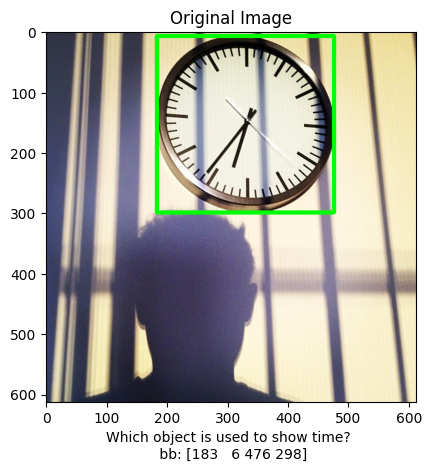

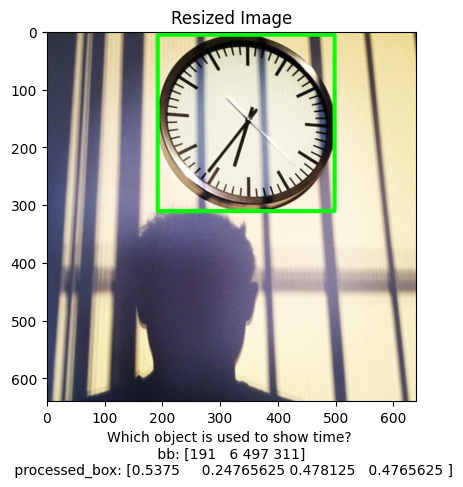

In [14]:
#Show 1 examples
import random

idx_list = random.sample(range(len(df_train)), 1)
for idx in idx_list:
    image_path, _, _, l, t, r, b, question = df_train.iloc[idx]
    new_image, new_bb , processed_box= image_box_processing(image_path, np.array([l, t, r, b]), question, show_example=True) #Image: (IMAGE_SIZE, IMAGE_SIZE, 3) | New Box: (x_center,y_center, new_w, new_h)
                                                                                                # Processed box of new box (normalised in [0, 1]): (X center, Y center, Width, Height)

### Question Processing

In [15]:
#Create the dictionary of questions
def make_vocab_questions(questions):
    
    """Make dictionary for questions and save them into text file."""

    print("- Creating a vocab list for questions")
    vocab_set = set()
    SENTENCE_SPLIT_REGEX = re.compile(r'(\W+)')
    question_length = []

    set_question_length = [None]*len(questions)
    for iquestion, question in enumerate(questions):
        words = SENTENCE_SPLIT_REGEX.split(question.lower())
        words = [w.strip() for w in words if len(w.strip()) > 0]
        vocab_set.update(words)
        set_question_length[iquestion] = len(words)
    question_length += set_question_length

    vocab_list = list(vocab_set)
    vocab_list.sort()
    vocab_list.insert(0, '<pad>')
    vocab_list.insert(1, '<unk>')
    print(f'    + The size of Question vocabbulary {len(vocab_list)}.')
    print(f'    + Maximum length of question: {np.max(question_length)}')
    return vocab_list, np.max(question_length)

In [16]:
def tokenize(sentence):

    """Split string lines into lists"""
    
    SENTENCE_SPLIT_REGEX = re.compile(r'(\W+)')
    tokens = SENTENCE_SPLIT_REGEX.split(sentence.lower())
    tokens = [t.strip() for t in tokens if len(t.strip()) > 0]
    return tokens

In [17]:
class Text_Dict:

    """Aim to convert index to word or word to index"""

    def __init__(self, vocab):
        
        self.word_list = vocab
        self.word2idx_dict = {w:n_w for n_w, w in enumerate(self.word_list)}
        self.vocab_size = len(self.word_list)
        self.unk2idx = self.word2idx_dict['<unk>'] if '<unk>' in self.word2idx_dict else None

    def idx2word(self, n_w):

        return self.word_list[n_w]

    def word2idx(self, w):
        if w in self.word2idx_dict:
            return self.word2idx_dict[w]
        elif self.unk2idx is not None:
            return self.unk2idx
        else:
            raise ValueError(f'word {w} not in dictionary (while dictionary does not contain <unk>)')

    def tokenize_and_index(self, sentence):
        inds = [self.word2idx(w) for w in tokenize(sentence)]

        return inds

### Data Loader

In [18]:
class Data_Loaders:

    """Aim to convert index to word or word to index"""

    def __init__(self, df_train, df_val, batch_size):
        
        self.df_train = df_train
        self.df_val = df_val
        self.batch_size = batch_size
        self.question_vocab, self.max_question_len = make_vocab_questions(pd.concat([df_train["question"],df_val["question"]], axis = 0))
        self.question_vocab_size = len(self.question_vocab)
        self.question_dict = Text_Dict(self.question_vocab)
        self.transform = transforms.Compose([transforms.ToTensor(),
                                             transforms.Normalize((0.485, 0.456, 0.406),\
                                                                  (0.229, 0.224, 0.225))])
    def vqa_processing(self,df):
        """Create a data list to store all raw data simples"""
        data = []
        for idx in range(len(df)):
            image_path, _, _, l, t, r,b, question = df.iloc[idx]
            data.append({
                "image_path" : image_path,
                "text_question": question,
                "bbox": np.array([l, t, r,b], dtype =np.float64) #Xmin Ymin Xmax Ymax
            })
        return data

    def data_processing(self, data, question_dict, transform):
        images = []
        text_questions = []
        token_questions = []
        bboxes = []
        image_paths = []
        for sample in data:
            resized_image,  bb_resized , processed_bb= image_box_processing(sample["image_path"], sample["bbox"], show_example = False)
            token_question = tokenize(sample["text_question"])
            question_2_idx = torch.tensor([question_dict.word2idx(w) for w in token_question])

            images.append(transform(resized_image))
            text_questions.append(sample["text_question"])
            token_questions.append(question_2_idx)
            if BOX_NORMALISATION:
                bboxes.append(processed_bb)
            else:
                bboxes.append(bb_resized)
            image_paths.append(sample["image_path"])
        bboxes = torch.tensor(bboxes)
        images = np.array([np.array(image) for image in images], dtype = np.float64)
        bboxes = np.array(bboxes, dtype = np.float64)
        bboxes = torch.tensor(bboxes)
        token_questions = nn.utils.rnn.pad_sequence(token_questions, padding_value = 0, batch_first =True)
        return {
            "image":torch.tensor(images),
            "question": token_questions,
            "text_question": text_questions,
            "bbox": bboxes,
            "image_path": image_paths
        }

    def train_loader(self):
        train_data = self.vqa_processing(self.df_train)
        train_loader = torch.utils.data.DataLoader(
            dataset=train_data,
            batch_size=self.batch_size,
            collate_fn=lambda x: self.data_processing(x, self.question_dict, self.transform))
        return train_loader

    def val_loader(self):
        train_data = self.vqa_processing(self.df_val)
        train_loader = torch.utils.data.DataLoader(
            dataset=train_data,
            batch_size=self.batch_size,
            collate_fn=lambda x: self.data_processing(x, self.question_dict, self.transform))
        return train_loader

In [19]:
data_loaders = Data_Loaders( df_train, df_val, BATCH_SIZE)
train_loader = data_loaders.train_loader()
val_loader = data_loaders.val_loader()

- Creating a vocab list for questions
    + The size of Question vocabbulary 2327.
    + Maximum length of question: 29


# Model

We implement the model named SAN form the paper [Stacked Attention Networks for Image Question Answering](https://arxiv.org/abs/1511.02274).\

The code of the model is from [https://github.com/zcyang/imageqa-san](https://github.com/zcyang/imageqa-san).

In [20]:
class ImageEncoder(nn.Module):

    def __init__(self, embedding_size):
        """
        Extract Image Features using 1 Dense Layer
        """
        super(ImageEncoder, self).__init__()
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(IMAGE_SIZE*IMAGE_SIZE*3, out_features = embedding_size)

    def forward(self, image):
        """Extract feature vector from image vector."""                 
        image_feature = self.flatten(image)
        image_feature = self.dense(image_feature)
        return image_feature

In [21]:
class QuestionEncoder(nn.Module):

    def __init__(self, question_vocab_size, word_embedding_size, embedding_size):
        """
        Extract question featues:
            - step 1: using word2vec
            - step 2: using LSTM
        """
        super(QuestionEncoder, self).__init__()
        self.word2vec = nn.Embedding(question_vocab_size, word_embedding_size)
        self.lstm = nn.LSTM(word_embedding_size, embedding_size, batch_first=True)

    def forward(self, question):
        question_vec = self.word2vec(question)
        _, (hidden, cell) = self.lstm(question_vec)
        return hidden[0]

In [22]:

class VqaModel(nn.Module):

    def __init__(self,embedding_size, question_vocab_size, word_embedding_size):
        """
        Fusing Image feature and question feature using Full Connected Layer
        """
        super(VqaModel, self).__init__()
        self.image_encoder = ImageEncoder(embedding_size)
        self.question_encoder = QuestionEncoder(question_vocab_size, word_embedding_size, embedding_size)
        self.dense = nn.Linear(embedding_size, 4)

    def forward(self, image, question):

        image_feature = self.image_encoder(image)
        question_feature = self.question_encoder(question)
        
        combined_feature = torch.mul(image_feature, question_feature)
        
        combined_feature = self.dense(combined_feature)
        return combined_feature

In [23]:

model = VqaModel(
        embedding_size=EMBEDIND_SIZE,
        question_vocab_size=data_loaders.question_vocab_size,
        word_embedding_size=WORD_EMBEDING_SIZE).to(DEVICE)

# Training

In [24]:
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=LEARNING_RATE)
loss_fn = nn.MSELoss(reduction='mean')

In [25]:
def bbox_iou(boxes1, boxes2):
    """
    Returns the IoU of two bounding boxes
    """
    # Get the coordinates of bounding boxes
    b1_x1, b1_y1, b1_x2, b1_y2 = boxes1[:, 0], boxes1[:, 1], boxes1[:, 2], boxes1[:, 3]
    b2_x1, b2_y1, b2_x2, b2_y2 = boxes2[:, 0], boxes2[:, 1], boxes2[:, 2], boxes2[:, 3]

    # get the coordinates of the intersection rectangle
    inter_rect_x1 = torch.max(b1_x1, b2_x1)
    inter_rect_y1 = torch.max(b1_y1, b2_y1)
    inter_rect_x2 = torch.min(b1_x2, b2_x2)
    inter_rect_y2 = torch.min(b1_y2, b2_y2)
    # Intersection area
    inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1, 0) * torch.clamp(inter_rect_y2 - inter_rect_y1, 0)
    # Union Area
    b1_area = (b1_x2 - b1_x1) * (b1_y2 - b1_y1)
    b2_area = (b2_x2 - b2_x1) * (b2_y2 - b2_y1)
    
    ious = inter_area / (b1_area + b2_area - inter_area + 1e-16)

    # print(box1, box1.shape)
    # print(box2, box2.shape)
    return ious

In [26]:
def xywh_to_xyxy_batch(boxes1, boxes2, img_size):
    boxes1 = boxes1*img_size
    boxes2 = boxes2*img_size
    boxes1[:,0], boxes1[:,2] = boxes1[:, 0] - boxes1[:, 2] / 2, boxes1[:, 0] + boxes1[:, 2] / 2
    boxes1[:,1], boxes1[:,3] = boxes1[:, 1] - boxes1[:, 3] / 2, boxes1[:, 1] + boxes1[:, 3] / 2
    boxes2[:,0], boxes2[:,2] = boxes2[:, 0] - boxes2[:, 2] / 2, boxes2[:, 0] + boxes2[:, 2] / 2
    boxes2[:,1], boxes2[:,3] = boxes2[:, 1] - boxes2[:, 3] / 2, boxes2[:, 1] + boxes2[:, 3] / 2
    return boxes1, boxes2

In [27]:
 def save_prediction(img_path, pred_bb, gt_bb, question, epoch):
    img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    result = img.copy()
    cv2.rectangle(result, (int(gt_bb[0]), int(gt_bb[1])), (int(gt_bb[2]), int(gt_bb[3])), (0, 255, 0), 3)
    cv2.rectangle(result, (int(pred_bb[0]), int(pred_bb[1])), (int(pred_bb[2]), int(pred_bb[3])), (255, 0, 0), 3)
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.title(question)
    plt.savefig(f"./saved_images/epoch_{epoch}_" + img_path.split("/")[-1])
    plt.close()

In [28]:
if LOG_WANDB:
    columns=["epoch", "dataset", "image", "iou"]
    train_table = wandb.Table(columns=columns)
    val_table = wandb.Table(columns=columns)

In [29]:
def epoch_train(model, train_loader, epoch):
    model.train()
    start_time = time.time()
    running_loss = 0.0
    running_iou = 0.0
    batch_step_size = len(data_loaders.df_train) / BATCH_SIZE
    train_step = epoch*batch_step_size
    for i, data in enumerate(train_loader):
        train_step += 1
        # get the inputs
        images, questions = data["image"].to(DEVICE).float(), data["question"].to(DEVICE)
        labels = data["bbox"].to(DEVICE).float()
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backwrd + optimiaze
        outputs = model(images, questions)
        loss = loss_fn(labels, outputs)
        loss.backward()
        optimizer.step()
        
        #Convert normalised xywh to xyXY
        if BOX_NORMALISATION:
            outputs, labels = xywh_to_xyxy_batch(outputs, labels, IMAGE_SIZE)
        

        #calculate IoU
        ious = bbox_iou(outputs, labels)
        mean_iou = torch.mean(ious)
        
        #Log to WandB for each batch (step)
        if LOG_WANDB:
            wandb.log({
                "train_step": train_step,
                "loss_step": loss.item(),
                "iou_step": mean_iou.item()
            })
        
        #Print performance
        running_loss += loss.item()
        running_iou += mean_iou.item()
        if (i+1) % 10 == 0:
            print(f"[{(i+1)*BATCH_SIZE}/{len(data_loaders.df_train)}] | Loss: {round(loss.item(),2)} | IoU: {round(mean_iou.item(),2)}")
    print(f"------------------------------------------------")
    running_loss = running_loss/batch_step_size
    running_iou = running_iou/batch_step_size
    
    #Log to WandB for each epoch    
    if LOG_WANDB:
        wandb.log({
            "epoch": epoch,
            "loss": running_loss,
            "iou": running_iou
        })
        if (epoch + 1) % SAVE_IMAGE_FREQ == 0:
            for idx in range(len(labels)):
                img_path = data['image_path'][idx]
                ques_text = data['text_question'][idx]
                target = labels[idx]
                prediction = outputs[idx]
                save_prediction(img_path, prediction, target, ques_text, epoch+1)
                train_table.add_data(epoch+1, "train", wandb.Image(f"./saved_images/epoch_{epoch+1}_" + img_path.split("/")[-1]), ious[idx].item())
    
    #Print the performance
    print(f"\nTraining performance: \n  Loss: {round(running_loss,2)} | IoU: {round(running_iou,2)} | Running Time {round((time.time() - start_time),2)} s")
    return running_loss, running_iou

In [30]:
def epoch_val(model, val_loader, epoch):
    val_running_loss = 0.0
    val_running_iou = 0.0
    model.train(False)
    start_time = time.time()
    val_batch_step_size = len(data_loaders.df_val) / BATCH_SIZE
    for i, data in enumerate(val_loader):
        # get the inputs
        images, questions = data["image"].to(DEVICE).float(), data["question"].to(DEVICE)
        
        labels = data["bbox"].to(DEVICE).float()
        # predict
        
        with torch.no_grad():
            predictions = model(images, questions)
            val_loss = loss_fn(predictions, labels)
        
        #Convert normalised xywh to xyXY
        if BOX_NORMALISATION:
            predictions, labels = xywh_to_xyxy_batch(predictions, labels, IMAGE_SIZE)
        
        #calculate IoU
        val_ious = bbox_iou( labels, predictions)
        val_mean_iou = torch.mean(val_ious)
        
        #Print performance
        val_running_loss += val_loss.item()
        val_running_iou += val_mean_iou.item()
        
    val_running_loss = val_running_loss/val_batch_step_size
    val_running_iou = val_running_iou/val_batch_step_size
    
    print(f"Validation performance| \n  Loss: {round(val_running_loss,2)} | IoU: {round(val_running_iou,2)} | Running Time {round((time.time() - start_time),2)}s \n")
    
    

    #Log to WandB for each epoch
    if LOG_WANDB:
        wandb.log({
            "val_loss":  val_running_loss,
            "val_iou": val_running_iou
        })
        if (epoch + 1) % SAVE_IMAGE_FREQ == 0:
            for idx in range(len(labels)):
                img_path = data['image_path'][idx]
                ques_text = data['text_question'][idx]
                target = labels[idx]
                prediction = predictions[idx]
                save_prediction(img_path, prediction, target, ques_text, epoch+1)
                val_table.add_data(epoch+1, "val", wandb.Image(f"./saved_images/epoch_{epoch+1}_" + img_path.split("/")[-1]), val_ious[idx].item())
        
    return val_running_loss, val_running_iou 

In [31]:
logs = {
        "loss": [],
        "iou":  [],
        "val_loss": [],
        "val_iou": []
}

model_file = f"./saved_models/best_model_{DATE.replace(':', '_').replace(' ', '_').replace('/', '_')}.pt"
max_val_iou = - np.float64('inf')


for epoch in range(NUM_EPOCHS):
    print("------------------------------------------------------------------------------------------------")
    print('------------------------------------------------------------------------------------------------')
    print(f"EPOCH {epoch+1}\n")
    

    training_loss, training_iou = epoch_train(model, train_loader, epoch)
    val_loss, val_iou = epoch_val(model, val_loader, epoch)
    
    #Save model
    if val_iou > max_val_iou:
        max_val_iou = val_iou
        torch.save(model, model_file)
    
    logs["loss"].append(training_loss)
    logs["iou"].append(training_iou)
    logs["val_loss"].append(val_loss)
    logs["val_iou"].append(val_iou)
print('Finished Training')

------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------
EPOCH 1

[320/3200] | Loss: 0.19 | IoU: 0.0
[640/3200] | Loss: 0.16 | IoU: 0.01
[960/3200] | Loss: 0.18 | IoU: 0.01
[1280/3200] | Loss: 0.15 | IoU: 0.01
[1600/3200] | Loss: 0.15 | IoU: 0.02
[1920/3200] | Loss: 0.18 | IoU: 0.0
[2240/3200] | Loss: 0.15 | IoU: 0.0
[2560/3200] | Loss: 0.18 | IoU: 0.0
[2880/3200] | Loss: 0.22 | IoU: 0.0
[3200/3200] | Loss: 0.13 | IoU: 0.0
------------------------------------------------

Training performance: 
  Loss: 0.17 | IoU: 0.01 | Running Time 52.73 s
1.0
Validation performance| 
  Loss: 0.16 | IoU: 0.0 | Running Time 0.45s 

------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------
EPOCH 2

[320/3200] | Loss: 0.13 | IoU: 0.02


Validation performance| 
  Loss: 0.19 | IoU: 0.0 | Running Time 0.42s 

------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------
EPOCH 12

[320/3200] | Loss: 0.06 | IoU: 0.07
[640/3200] | Loss: 0.06 | IoU: 0.06
[960/3200] | Loss: 0.06 | IoU: 0.07
[1280/3200] | Loss: 0.06 | IoU: 0.05
[1600/3200] | Loss: 0.04 | IoU: 0.08
[1920/3200] | Loss: 0.05 | IoU: 0.08
[2240/3200] | Loss: 0.06 | IoU: 0.04
[2560/3200] | Loss: 0.04 | IoU: 0.05
[2880/3200] | Loss: 0.06 | IoU: 0.05
[3200/3200] | Loss: 0.04 | IoU: 0.02
------------------------------------------------

Training performance: 
  Loss: 0.06 | IoU: 0.05 | Running Time 55.09 s
1.0
Validation performance| 
  Loss: 0.19 | IoU: 0.0 | Running Time 0.43s 

------------------------------------------------------------------------------------------------
---------------------------------------------------------------

[2560/3200] | Loss: 0.01 | IoU: 0.15
[2880/3200] | Loss: 0.03 | IoU: 0.14
[3200/3200] | Loss: 0.02 | IoU: 0.1
------------------------------------------------

Training performance: 
  Loss: 0.03 | IoU: 0.13 | Running Time 54.82 s
1.0
Validation performance| 
  Loss: 0.21 | IoU: 0.01 | Running Time 0.51s 

------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------
EPOCH 23

[320/3200] | Loss: 0.03 | IoU: 0.12
[640/3200] | Loss: 0.03 | IoU: 0.12
[960/3200] | Loss: 0.02 | IoU: 0.17
[1280/3200] | Loss: 0.02 | IoU: 0.15
[1600/3200] | Loss: 0.01 | IoU: 0.27
[1920/3200] | Loss: 0.02 | IoU: 0.19
[2240/3200] | Loss: 0.02 | IoU: 0.15
[2560/3200] | Loss: 0.01 | IoU: 0.16
[2880/3200] | Loss: 0.03 | IoU: 0.15
[3200/3200] | Loss: 0.02 | IoU: 0.1
------------------------------------------------

Training performance: 
  Loss: 0.03 | IoU: 0.13 | Running Time 56.16 s
1

[640/3200] | Loss: 0.02 | IoU: 0.21
[960/3200] | Loss: 0.01 | IoU: 0.2
[1280/3200] | Loss: 0.02 | IoU: 0.15
[1600/3200] | Loss: 0.01 | IoU: 0.24
[1920/3200] | Loss: 0.02 | IoU: 0.18
[2240/3200] | Loss: 0.01 | IoU: 0.17
[2560/3200] | Loss: 0.01 | IoU: 0.16
[2880/3200] | Loss: 0.02 | IoU: 0.13
[3200/3200] | Loss: 0.02 | IoU: 0.09
------------------------------------------------

Training performance: 
  Loss: 0.02 | IoU: 0.14 | Running Time 54.92 s
1.0
Validation performance| 
  Loss: 0.26 | IoU: 0.01 | Running Time 0.46s 

------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------
EPOCH 34

[320/3200] | Loss: 0.03 | IoU: 0.12
[640/3200] | Loss: 0.03 | IoU: 0.14
[960/3200] | Loss: 0.03 | IoU: 0.11
[1280/3200] | Loss: 0.02 | IoU: 0.08
[1600/3200] | Loss: 0.02 | IoU: 0.13
[1920/3200] | Loss: 0.04 | IoU: 0.11
[2240/3200] | Loss: 0.03 | IoU: 0.07
[2560/3200] 

[320/3200] | Loss: 0.03 | IoU: 0.09
[640/3200] | Loss: 0.05 | IoU: 0.08


KeyboardInterrupt: 

# Training Visulization

In [1]:
plt.figure()
plt.plot(logs["loss"], label = "train")
plt.plot(logs["val_loss"], label = "val")
plt.title(f"loss \n learning_rate = {LEARNING_RATE} | Num epo = {NUM_EPOCHS}")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("Mean Square Error")
plt.show()

NameError: name 'plt' is not defined

In [ ]:
plt.figure()
plt.plot(logs["iou"], label = "train")
plt.plot(logs["val_iou"], label = "val")
plt.title(f"IoU \n learning_rate = {LEARNING_RATE} | Num epo = {NUM_EPOCHS}")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("IoU")
plt.show()

In [ ]:
if LOG_WANDB:
    wandb.log({"train example": train_table})
    wandb.log({"val example": val_table})
    os.system('rm -rf saved_images')
    wandb.finish()